In [34]:
#This program takes about 60 minutes to run
#Loading Package
import os

import time
import numpy as np
import scipy as sci
import scipy.io as sio
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow import keras


from numpy.random import seed
seed(100)


import matplotlib.pyplot as plt
from IPython.display import clear_output


# Exploratory Data Analysis

In [35]:
# load raw data
DATA_FOLDER = './Data'
raw = pd.read_csv(os.path.join('Implied_Volatility_Data_vFinal.csv'), parse_dates= ["Date"])

In [36]:
# check the raw data
print("Size of the dataset (row, col): ", raw.shape)
raw.head(2)

Size of the dataset (row, col):  (125700, 5)


,Date,SPX Return,Time to Maturity in Year,Delta,Implied Volatility Change
0,2014-06-30,0.006678,0.184,0.745927,0.008462
1,2014-06-30,0.006678,2.252,0.286911,0.002024


In [37]:
vix = pd.read_csv(os.path.join('VIX.csv'), parse_dates= ["Date"], infer_datetime_format=True)
vix[['Open','Adj Close']] = vix[['Open','Adj Close']]/np.sqrt(252)
vix.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-06-30,0.740180,11.81,11.30,11.57,0.728841,0
1,2014-07-01,0.710573,11.42,10.92,11.15,0.702384,0


In [38]:
raw_with_vix = raw.merge(vix[["Open", "Adj Close"]], how="left", left_on= raw["Date"], right_on = vix["Date"] )
raw_with_vix.rename(columns={"Open": "VIX Open", "Adj Close": "VIX Close"}, inplace = True)
raw_with_vix = raw_with_vix.iloc[:,1:]

In [39]:
raw_with_vix.head(2)

,Date,SPX Return,Time to Maturity in Year,Delta,Implied Volatility Change,VIX Open,VIX Close
0,2014-06-30,0.006678,0.184,0.745927,0.008462,0.74018,0.728841
1,2014-06-30,0.006678,2.252,0.286911,0.002024,0.74018,0.728841


## Construct the 3 variables for Regression Approach

In [40]:
# construct the 3 variables for regression
raw_with_vix['x1'] = raw_with_vix['SPX Return'] / np.sqrt(raw_with_vix['Time to Maturity in Year'])
raw_with_vix['x2'] = raw_with_vix['SPX Return'] / np.sqrt(raw_with_vix['Time to Maturity in Year']) * raw_with_vix['Delta']
raw_with_vix['x3'] = raw_with_vix['x2'] * raw_with_vix['Delta']

# Put the X and Y variable in data frame for regression
y = raw_with_vix['Implied Volatility Change']

# Simple model with complete dataset (With VIX)
X_Vix = raw_with_vix[['x1', 'x2', 'x3', 'VIX Close']]

# Simple model with VIX as a feature
X = X_Vix.iloc[:,:-1]


X_2 = raw_with_vix[['SPX Return', 'Time to Maturity in Year', 'Delta']]

In [41]:
# ensure no null values
raw_with_vix.isnull().sum().sort_values(ascending = False)/raw.shape[0]

Date                         0.0
SPX Return                   0.0
Time to Maturity in Year     0.0
Delta                        0.0
Implied Volatility Change    0.0
VIX Open                     0.0
VIX Close                    0.0
x1                           0.0
x2                           0.0
x3                           0.0
dtype: float64

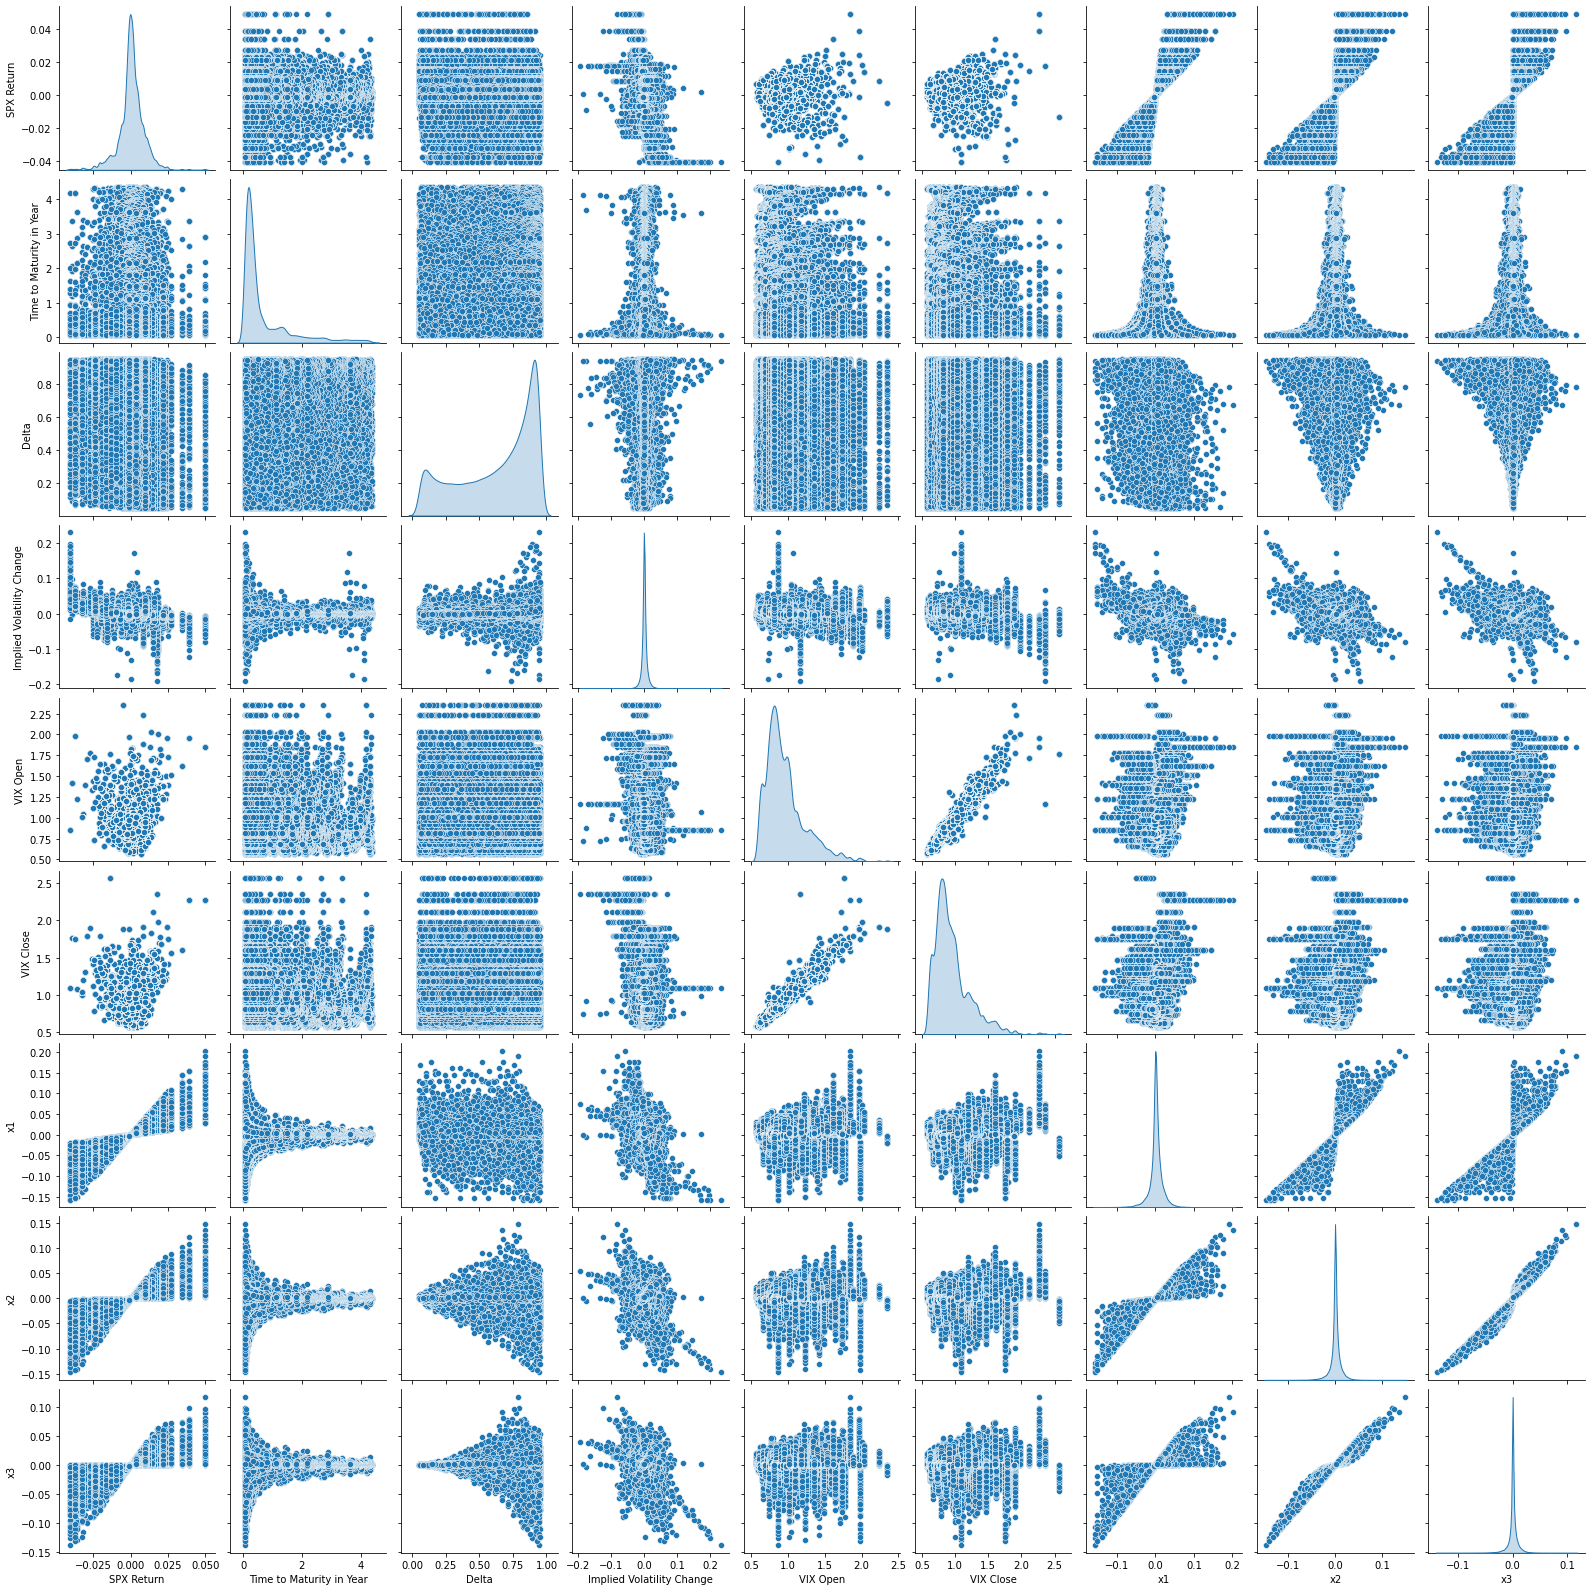

In [26]:
# sns.pairplot(raw_with_vix, diag_kind = 'kde')

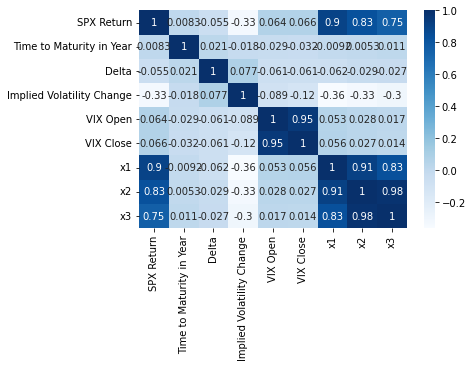

In [27]:
sns.heatmap(raw_with_vix.corr(), cmap = 'Blues',annot= True)
plt.savefig('Correl.jpg')
plt.show()

# Create splits for data

In [28]:
def get_train_val_test(x, y):
    '''
    Input: y pred, x features
    Output: train, val and test splits from dataset, assigned to var "split_x"
    Map: x: split_x[0][0 to 2] , y: split_x[1][0 to 2] arrangement: train, val, test
    '''
    # Divide data into training set and test set with 1:1 Split
    X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.5,random_state=100)

    # Divide training set into training and validation set
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.5,random_state=100)

    return [[X_train, X_val, X_test] ,[y_train, y_val, y_test]]

# Split 1, 2: Simple model without VIX, with VIX   
split_1, split_2= get_train_val_test(X,y), get_train_val_test(X_Vix,y)

# Split 3, 4: NN model (not using simple model) without Vix, with Vix
nnx_vix = raw_with_vix[['SPX Return','Time to Maturity in Year', 'Delta', 'VIX Close']]
nnx = nnx_vix.iloc[:,:-1]
split_3, split_4= get_train_val_test(nnx,y), get_train_val_test(nnx_vix,y)

# Learning Journal Point
split_lj = get_train_val_test(X_2, y)

In [29]:
# Train, Val, Test without VIX
print('-----Split 1-----')
# [print(i.head(1)) for i in split_1[1]]
split_1[0][0].head(2)

-----Split 1-----


,x1,x2,x3
60364,-0.002604,-0.001852,-0.001317
43377,0.000491,0.000111,0.000025


In [30]:
# Train, Val, Test with VIX
print('-----Split 2-----')
# [print(i.head(1)) for i in split_2[1]]
split_2[0][0].head(2)

-----Split 2-----


,x1,x2,x3,VIX Close
60364,-0.002604,-0.001852,-0.001317,0.840971
43377,0.000491,0.000111,0.000025,0.883177


In [31]:
# Train, Val, Test with VIX
print('-----Split 3-----')
split_3[0][0].head(2)

-----Split 3-----


,SPX Return,Time to Maturity in Year,Delta
60364,-0.002387,0.840,0.711139
43377,0.000986,4.028,0.227012


In [32]:
# Train, Val, Test with VIX
print('-----Split 4-----')
split_4[0][0].head(2)

-----Split 4-----


,SPX Return,Time to Maturity in Year,Delta,VIX Close
60364,-0.002387,0.840,0.711139,0.840971
43377,0.000986,4.028,0.227012,0.883177


# Perform Z-score scaling

In [33]:
def scale_data(split_x):
    # Assign variables
    X_train, X_val, X_test = split_x[0]

    # Scale features based on Z-Score
    scaler = StandardScaler()
    scaler.fit(X_train)

    X_scaled_train = scaler.transform(X_train)
    X_scaled_vals = scaler.transform(X_val)
    X_scaled_test = scaler.transform(X_test)

    return [[X_scaled_train, X_scaled_vals, X_scaled_test], [np.asarray(i) for i in split_x[1]]]

# Scale all splits in the format [[x_scaled_train, x_scaled_val, x_scaled_test], [y_train, y_val, y_test]]
scaled_split_1, scaled_split_2, scaled_split_3, scaled_split_4 = scale_data(split_1), scale_data(split_2), scale_data(split_3), scale_data(split_4)

In [42]:
scaled_split_lj = scale_data(split_lj)

# Fitting LR model

In [45]:
# Validation set results without VIX   
lr_wo_vix = LinearRegression(fit_intercept=False)
lr_wo_vix.fit(scaled_split_1[0][0], scaled_split_1[1][0])

# Get the prediction
y_pred_1 = lr_wo_vix.predict(scaled_split_1[0][2])

# Calculate Mean Squared Error
lr_mse_wo_vix = mean_squared_error(scaled_split_1[1][2], y_pred_1)

print('Validation Test loss without VIX (MSE):', lr_mse_wo_vix)

Validation Test loss without VIX (MSE): 7.632364938220805e-05


In [43]:
# Validation set results without VIX   
lr_lj = LinearRegression(fit_intercept=False)
lr_lj.fit(scaled_split_lj[0][0], scaled_split_lj[1][0])

# Get the prediction
y_pred_lj = lr_lj.predict(scaled_split_1[0][2])

# Calculate Mean Squared Error
lr_mse_lj = mean_squared_error(scaled_split_lj[1][2], y_pred_lj)

print('Validation Test loss LJ (MSE):', lr_mse_lj)

Validation Test loss LJ (MSE): 7.688608879017142e-05


In [52]:
print((lr_mse_lj-lr_mse_wo_vix)/lr_mse_wo_vix)

0.007369136729126072


In [114]:
# Validation set results with VIX   
lr_vix = LinearRegression(fit_intercept=False)
lr_vix.fit(scaled_split_2[0][0], scaled_split_2[1][0])

# Get the prediction
y_pred_2 = lr_vix.predict(scaled_split_2[0][2])

# Calculate Mean Squared Error
lr_mse_vix = mean_squared_error(scaled_split_2[1][2], y_pred_2)

print('Validation Test loss with VIX (MSE):', lr_mse_vix)

Validation Test loss with VIX (MSE): 7.552458231722083e-05


# Fitting NN Model

In [115]:
# Creating base models
model_wo_vix = keras.models.Sequential([Dense(20,activation = "sigmoid",input_shape = (3,)),
                                        Dense(20,activation = "sigmoid"),Dense(20,activation = "sigmoid"),
                                        Dense(1)])
model_vix = keras.models.Sequential([Dense(20,activation = "sigmoid",input_shape = (4,)),
                                    Dense(20,activation = "sigmoid"),Dense(20,activation = "sigmoid"),
                                    Dense(1)])

In [116]:
# Create checkpoints and early stops
checkpoint_names = ['implied_vol_wo_vix.h5', 'implied_vol_vix.h5']

checkpoint_earlystop = [[keras.callbacks.ModelCheckpoint(i,save_best_only = True),
                        keras.callbacks.EarlyStopping(patience = 1000,restore_best_weights = True)] for i in checkpoint_names]

In [117]:
# Fit the nn models
fitted_models, base_models, nn_scaled_splits = [], (model_wo_vix, model_vix),(scaled_split_3, scaled_split_4)

for i in range(2):
    # Complie function allows you to choose your measure of loss and optimzer
    base_models[i].compile(loss = "mse",optimizer = "Adam")

    # Fit the models with the params
    fitted_models.append(base_models[i].fit(nn_scaled_splits[i][0][0], nn_scaled_splits[i][1][0],
                                            epochs=50000, 
                                            batch_size = 128, 
                                            verbose = 0, 
                                            validation_data=(nn_scaled_splits[i][0][1], nn_scaled_splits[i][1][1]),
                                            callbacks=[checkpoint_earlystop[i]]
                                            ) 
                        )

## Review NN results


---NN model with VIX---


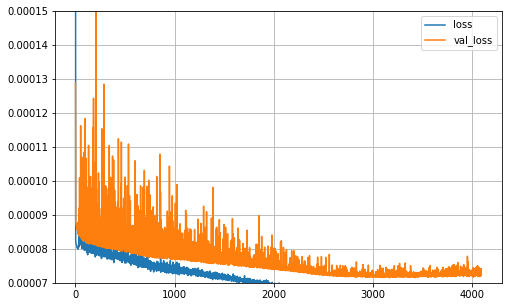

---NN model with VIX---


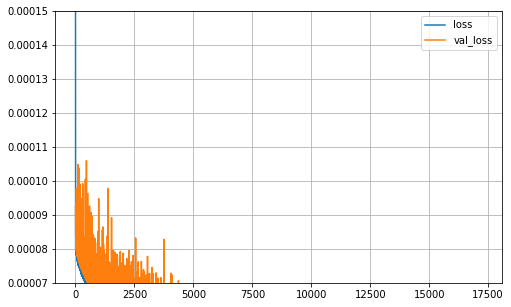

In [120]:
# Plot training history
output_dfs = []

for i in fitted_models:
    if i == 0:
        print('---NN model without VIX---')
    else:
        print('---NN model with VIX---')
    df = pd.DataFrame(i.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0.00007,0.00015)
    plt.show()

    #Export your training history for MSE
    output = pd.DataFrame(i.history)
    output_dfs.append(output)

# Review performance measures

In [121]:
# Load and evaluate best models 
best_nn_models, nn_mse = [],[]

for i in range(2):
    # Load and store models 
    model = keras.models.load_model(checkpoint_names[i])
    best_nn_models.append(model)

    # Obtain and store MSE
    mse_test = model.evaluate(nn_scaled_splits[i][0][2], nn_scaled_splits[i][1][2],
                              verbose = 0)
    nn_mse.append(mse_test)

    # Print Results

    if i == 0: 
        print('Performance measures without VIX')
        print('Test Loss without VIX (MSE): ', nn_mse[i])
        print('Gain Ratio without VIX: ', round(100*(1-(nn_mse[i]/lr_mse_wo_vix)),2), ' %')
        print('-----')
    elif i == 1:
        print('Performance measures with VIX')
        print('Test Loss with VIX (MSE): ', nn_mse[i])
        print('Gain Ratio with VIX: ', round(100*(1-(nn_mse[i]/lr_mse_vix)),2), ' %')   
     

Performance measures without VIX
Test Loss without VIX (MSE):  6.43347084405832e-05
Gain Ratio without VIX:  15.71  %
-----
Performance measures with VIX
Test Loss with VIX (MSE):  5.24568313267082e-05
Gain Ratio with VIX:  30.54  %
